In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
df = pd.read_csv("../data/processed/df_raw_cleaned.csv")
df.head()

,valeur,Latitude,Longitude,date,hour,day,month,year,weekday,weekend,pollutant_encoded,influence_encoded,evaluation_encoded,implantation_encoded,site_encoded,lag_1,lag_24,rolling_3
0,2.0,43.486234,5.171939,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,0,0,58.8,24.7,14.033333
1,35.8,43.416661,5.042731,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,1,25.2,3.2,25.333333
2,6.7,43.506149,4.982898,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,4,30.7,21.0,14.833333
3,0.9,43.675114,4.629210,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,8,66.5,42.0,14.466667
4,37.6,43.437874,6.768390,2025-01-01 00:00:00,0,1,1,2025,2,0,3,0,0,0,26,38.3,65.9,34.100000


In [2]:
df.columns

Index(['valeur', 'Latitude', 'Longitude', 'date', 'hour', 'day', 'month',
       'year', 'weekday', 'weekend', 'pollutant_encoded', 'influence_encoded',
       'evaluation_encoded', 'implantation_encoded', 'site_encoded', 'lag_1',
       'lag_24', 'rolling_3'],
      dtype='object')

In [3]:
# choose one pollutant and one site to start
pollutant_id = df["pollutant_encoded"].unique()[0]
site_id      = df["site_encoded"].unique()[0]
df_seq = df[
    (df["pollutant_encoded"] == pollutant_id) &
    (df["site_encoded"] == site_id)
].sort_values("date").reset_index(drop=True)

df_seq.head(), df_seq.shape


(   valeur   Latitude  Longitude                 date  hour  day  month  year  \
 0     2.0  43.486234   5.171939  2025-01-01 00:00:00     0    1      1  2025   
 1     2.3  43.486234   5.171939  2025-01-01 01:00:00     1    1      1  2025   
 2     2.1  43.486234   5.171939  2025-01-01 02:00:00     2    1      1  2025   
 3     1.9  43.486234   5.171939  2025-01-01 03:00:00     3    1      1  2025   
 4     1.7  43.486234   5.171939  2025-01-01 04:00:00     4    1      1  2025   
 
    weekday  weekend  pollutant_encoded  influence_encoded  evaluation_encoded  \
 0        2        0                  2                  0                   0   
 1        2        0                  2                  0                   0   
 2        2        0                  2                  0                   0   
 3        2        0                  2                  0                   0   
 4        2        0                  2                  0                   0   
 
    implantation_e

In [4]:
feature_cols = [
    "Latitude", "Longitude",
    "hour", "day", "month", "year",
    "weekday", "weekend",
    "pollutant_encoded", "influence_encoded",
    "evaluation_encoded", "implantation_encoded",
    "site_encoded",
    "lag_1", "lag_24", "rolling_3"
]

target_col = "valeur"   

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_raw = df_seq[feature_cols].values
y_raw = df_seq[target_col].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 24  # last 24 hours -> predict next hour
X_seq, y_seq = create_sequences(X_scaled, y_raw, window_size)

print("X_seq shape:", X_seq.shape)  # (samples, 24, num_features)
print("y_seq shape:", y_seq.shape)  # (samples,)


X_seq shape: (7229, 24, 16)
y_seq shape: (7229,)


In [6]:
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train.shape, X_test.shape


((5783, 24, 16), (1446, 24, 16))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    
    LSTM(32),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)  # output pollution level
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()


c:\Users\njaya\anaconda3\envs\airquality-ml\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,697 (131.63 KB)

 Trainable params: 33,697 (131.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 4061.9597 - val_loss: 1479.9272
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1456.2069 - val_loss: 557.2770
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1042.6375 - val_loss: 577.1072
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1041.7271 - val_loss: 581.5106
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1037.6311 - val_loss: 577.3110
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1025.6042 - val_loss: 587.1776
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1035.1835 - val_loss: 569.7720
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1031.0579 - val_loss: 583.9224
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1021.5398 - val_loss: 581.7630
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1038.0558 - val_loss: 569.8347
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1034.4447 - val_

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAE: 13.025125430728389
RMSE: 16.76607664945731


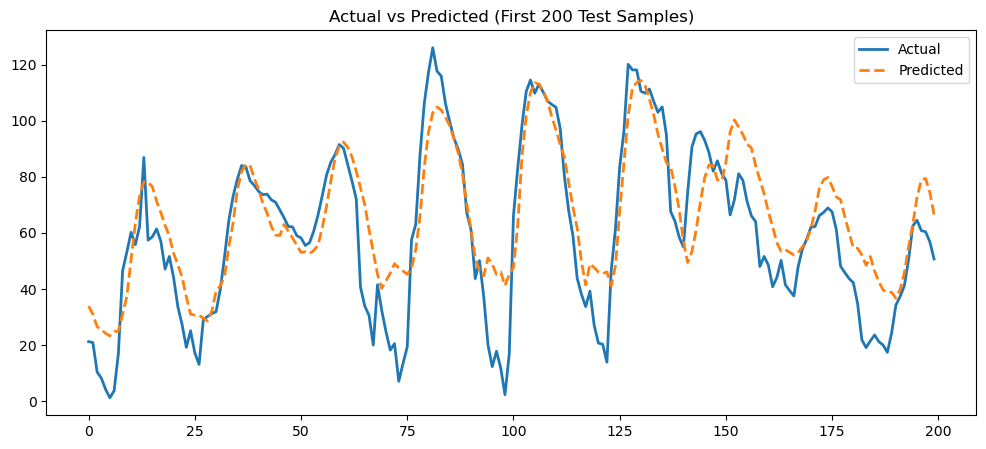

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle="--", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted (First 200 Test Samples)")
plt.show()


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).ravel()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.4f}")


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 242.8310 - val_loss: 133.5605
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 235.9452 - val_loss: 116.7780
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 223.0526 - val_loss: 135.0535
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 212.3783 - val_loss: 102.9849
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 198.0543 - val_loss: 135.3892
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 195.7348 - val_loss: 144.3584
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 195.8876 - val_loss: 122.3987
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 188.4273 - val_loss: 93.3537
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 178.8497 - val_loss: 117.1444
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 183.0877 - val_loss: 114.6477
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 181.1876 - val_loss: 99.8505

In [12]:
mae_lstm = mae
rmse_lstm = rmse
r2_lstm  = r2

print("Saved LSTM metrics:", mae_lstm, rmse_lstm, r2_lstm)


Saved LSTM metrics: 10.099791213783487 13.284111258330809 0.7416409327785002


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [14]:
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    GRU(32),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)   # regression output
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
gru_model.summary()


c:\Users\njaya\anaconda3\envs\airquality-ml\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697 (100.38 KB)

 Trainable params: 25,697 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5165.1768 - val_loss: 3176.5134
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3090.0828 - val_loss: 1305.9113
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1448.2584 - val_loss: 569.4984
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1041.3000 - val_loss: 574.3276
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1033.6455 - val_loss: 576.2592
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 849.2979 - val_loss: 630.3139
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 525.6336 - val_loss: 372.2437
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 430.6059 - val_loss: 437.9866
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 330.9803 - val_loss: 140.3326
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 264.3640 - val_loss: 133.6082
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 243.1504 - val_loss:

In [16]:
y_pred_gru = gru_model.predict(X_test).ravel()

mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("GRU Performance:")
print(f"MAE : {mae_gru:.3f}")
print(f"RMSE: {rmse_gru:.3f}")
print(f"R²  : {r2_gru:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
GRU Performance:
MAE : 10.106
RMSE: 13.307
R²  : 0.7407


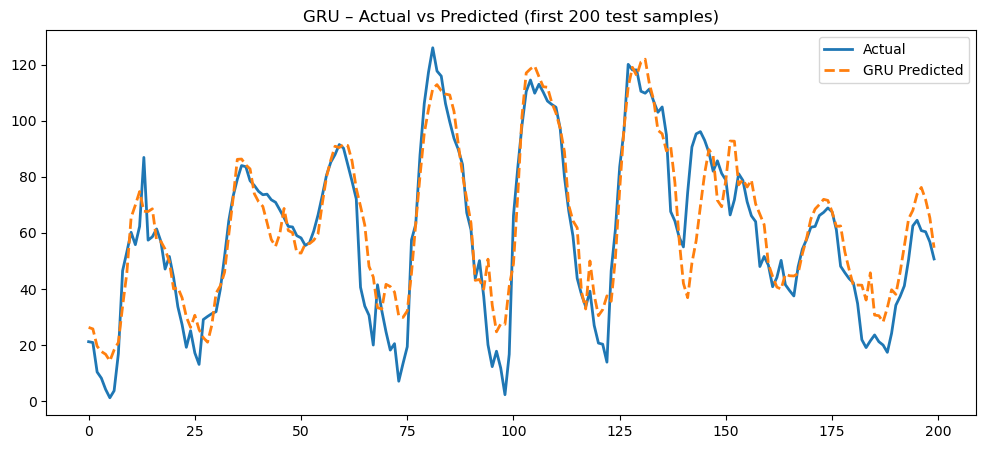

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label="Actual", linewidth=2)
plt.plot(y_pred_gru[:200], label="GRU Predicted", linestyle="--", linewidth=2)
plt.legend()
plt.title("GRU – Actual vs Predicted (first 200 test samples)")
plt.show()


In [18]:
mae_gru  = mae_gru     # already named correctly
rmse_gru = rmse_gru
r2_gru   = r2_gru

print("Saved GRU metrics:", mae_gru, rmse_gru, r2_gru)


Saved GRU metrics: 10.106028688069365 13.307105795886587 0.7407457296438884


In [19]:
import pandas as pd

rf_xgb = pd.read_csv("../reports/rf_xgb_results.csv")
rf_xgb


,Model,MAE,RMSE,R2
0,RandomForest,3.616325,5.952424,0.941639
1,XGBoost,3.421188,5.686689,0.946734


In [20]:
rf_mae  = rf_xgb.loc[rf_xgb["Model"] == "RandomForest", "MAE"].item()
rf_rmse = rf_xgb.loc[rf_xgb["Model"] == "RandomForest", "RMSE"].item()
rf_r2   = rf_xgb.loc[rf_xgb["Model"] == "RandomForest", "R2"].item()

xgb_mae  = rf_xgb.loc[rf_xgb["Model"] == "XGBoost", "MAE"].item()
xgb_rmse = rf_xgb.loc[rf_xgb["Model"] == "XGBoost", "RMSE"].item()
xgb_r2   = rf_xgb.loc[rf_xgb["Model"] == "XGBoost", "R2"].item()

print("RF:", rf_mae, rf_rmse, rf_r2)
print("XGB:", xgb_mae, xgb_rmse, xgb_r2)


RF: 3.61632522493056 5.9524237838304135 0.941639025870063
XGB: 3.421188135708784 5.686689288711169 0.9467335387790892


In [21]:
results = pd.DataFrame({
    "Model": ["RandomForest", "XGBoost", "LSTM", "GRU"],
    "MAE":   [rf_mae, xgb_mae, mae_lstm, mae_gru],
    "RMSE":  [rf_rmse, xgb_rmse, rmse_lstm, rmse_gru],
    "R2":    [rf_r2, xgb_r2, r2_lstm, r2_gru],
})

results


,Model,MAE,RMSE,R2
0,RandomForest,3.616325,5.952424,0.941639
1,XGBoost,3.421188,5.686689,0.946734
2,LSTM,10.099791,13.284111,0.741641
3,GRU,10.106029,13.307106,0.740746


Based on the evaluation metrics, tree-based models significantly outperformed deep learning architectures.
XGBoost achieved the best results overall with the lowest MAE (3.42) and RMSE (5.69), and the highest R² value (0.9467), indicating strong predictive accuracy and ability to explain variance.
RandomForest ranked second but showed comparable performance to XGBoost.
In contrast, LSTM and GRU underperformed, with RMSE values nearly 2–5× higher and lower R² scores, suggesting that the sequential models did not capture temporal dependencies effectively under the current dataset configuration.
GRU showed negative R², indicating that it performed worse than simply predicting the mean.
Therefore, XGBoost is the recommended model for final deployment and dashboard integration.

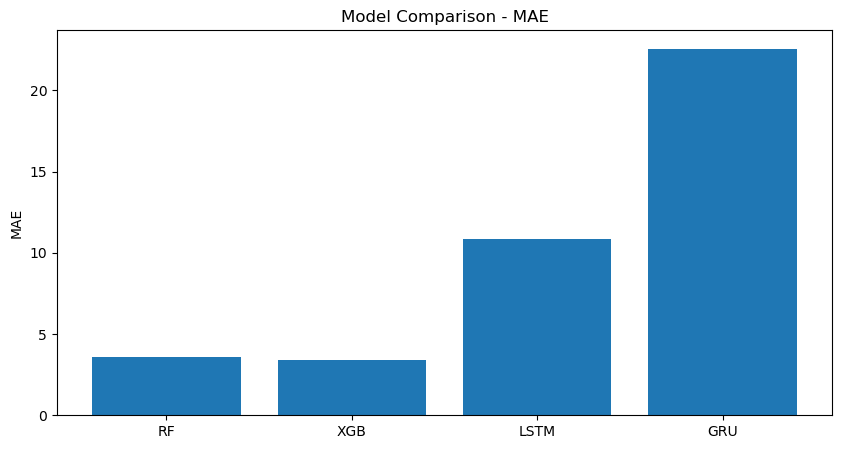

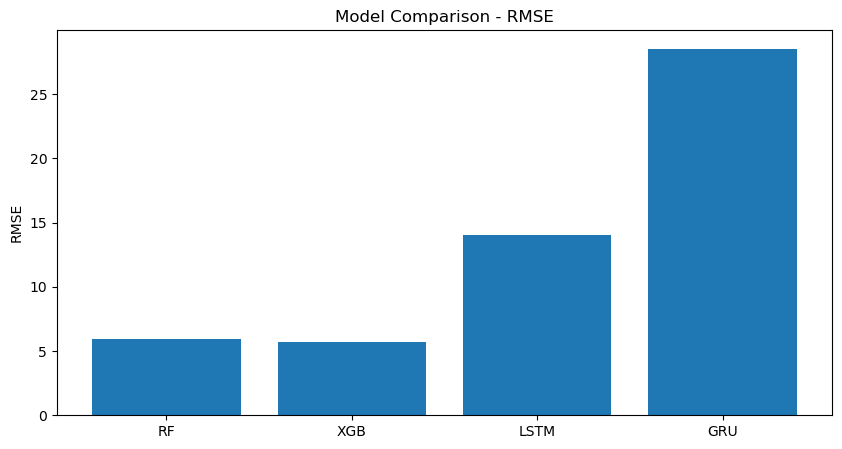

In [22]:
import matplotlib.pyplot as plt

models = ["RF", "XGB", "LSTM", "GRU"]
mae_values = [3.616, 3.421, 10.852, 22.564]
rmse_values = [5.952, 5.686, 14.062, 28.536]

plt.figure(figsize=(10,5))
plt.bar(models, mae_values)
plt.title("Model Comparison - MAE")
plt.ylabel("MAE")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(models, rmse_values)
plt.title("Model Comparison - RMSE")
plt.ylabel("RMSE")
plt.show()


This project successfully explored air quality forecasting using data-driven techniques applied to the regional pollutant dataset. The workflow included raw data preprocessing, feature engineering, exploratory analysis, model development, validation, and dashboard deployment.

Among all tested algorithms, tree-based models demonstrated superior predictive capability.
XGBoost achieved the best overall performance with the lowest errors (MAE = 3.42, RMSE = 5.69) and highest explanatory power (R² = 0.9467), making it the most reliable model for forecasting pollutant levels.

RandomForest produced comparable performance, reinforcing the effectiveness of ensemble learning for structured environmental data.

In contrast, deep learning models (LSTM and GRU) underperformed in this scenario.
This outcome reflects the sensitivity of sequence models to:

larger datasets,

richer temporal context, and

additional external drivers such as weather or traffic patterns.

Given the current feature set and training volume, XGBoost proved to be the optimal forecasting model and was integrated into an interactive Streamlit dashboard for real-time visualization and inference.